# Non deep learning models

### Todo

Polish code

Write up a tuning guide to our different models/ link to api 

Perhaps eliminate Random Forest as is it boosted trees run with a specific parameter set
Seems to always give worse results than boosted and might therefore be redundant

add safety for overwriting (final results left)

add show p values for logistic regression (on hold for now, sklearn does not support this natively)

add final results code with test data

look into statistical means of determining if the difference in results between two approaches are significant

#### This cell is for defining various OPTIONS used for this notebook (working directory, how many rows and columns pandas displays for a dataframe, etc). 

#### Preferably this cell is also where we do important imports (for example pandas and numpy)

In [83]:
import os 
#Input the directory where your joined_data.csv is located 
#os.chdir('C:/Users/Trond/Documents/Master 2020/Processed data')
os.chdir('C:/Users/Briggstone/Documents/Master 2020/Processed data')
#os.chdir('C:/Users/MyPC/Documents/Andrijana/UiS/DATMAS Master oppgave/Processed data')

#Where you want the csv file of the merged data to be placed
output_filepath = 'C:/Users/Briggstone/Documents/Master 2020/Processed data'
#output_filepath = 'C:/Users/MyPC/Documents/Andrijana/UiS/DATMAS Master oppgave/Processed data'

from matplotlib import pyplot
import pandas as pd 
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics as met
from scipy import stats
import json

# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)


"""
Initial flags and Options that are constant for all models
"""
#Here we set a seed so that our random search produce the same result 
np.random.seed(31415)

# Here we create a scoring dictionary which defines the metrics we report on in cross validation
scoring = {
    'accuracy': met.make_scorer(met.accuracy_score),
    'precision': met.make_scorer(met.precision_score),
    'sensitivity': met.make_scorer(met.recall_score),
    'specificity': met.make_scorer(met.recall_score,pos_label = 0),
    'f1': met.make_scorer(met.f1_score),
    'roc_auc': met.make_scorer(met.roc_auc_score),
    "MCC" : met.make_scorer(met.matthews_corrcoef)
}

# This is the metric we seek to optimise through tuning
refit = "MCC"

# Which folder of preprocessed data we want to use
FOLDER_NAME = "example"

#Whether to print information about the percentage of positive cases in our train and test sets
POSITIVE_CASES_PRINT = 1

#Use this to set the number of CPU threads used for cross validation and tuning
#CV and tuning can be very cpu intensive and if your cpu runs hot, its advised to not run all cores, though the code will take longer to run
#I crashed my computer to blue screen when running cpu at 100% for a period, not fun. My computer is a bit unstable due to overclocking though :P

CV_TUNING_N_CORES = 4

"""
"""

#Just to stop \n being printed out due to the open strings
clear = 1


#### In this cell we import our training data and drop PATNO and SMOTE helper colums

In [84]:
train = pd.read_csv(FOLDER_NAME + '/train.csv')

#We read our SMOTE helper column into a variable and then drop it
SAMPLING = train.SAMPLING.values[0]
train.drop(["SAMPLING"], axis = 1, inplace = True)


# We drop PATNO
train.drop(["PATNO"], axis = 1, inplace = True)


# We form Y
train_Y = train.pop("HALL")



if POSITIVE_CASES_PRINT:
    print("(The number of subjects, number of features) in training set", train.shape)
    print("Number of patients which hallucinates eventually in training set is ",  sum(train_Y), " which is ", sum(train_Y)/ (train_Y.size), " percent of patients")

#Important for xgboost class weight balancing
num_pos_samples = sum(train_Y)
num_neg_samples = train_Y.size - num_pos_samples
pos_weights_scale = num_neg_samples / num_pos_samples

(The number of subjects, number of features) in training set (283, 92)
Number of patients which hallucinates eventually in training set is  65.0  which is  0.22968197879858657  percent of patients


#### In this cell we import our test data (if flag is set) and drop PATNO and SMOTE helper columns

In [85]:
test = pd.read_csv(FOLDER_NAME + '/test.csv')

# We drop PATNO
test.drop(["PATNO"], axis = 1, inplace = True)

# We form Y
test_Y = test.pop("HALL")

if POSITIVE_CASES_PRINT:
    print("(The number of subjects, number of features) in test set", test.shape)
    print("Number of patients which hallucinates eventually in test set is ",  sum(test_Y), " which is ", sum(test_Y)/ (test_Y.size), " percent of patients")


(The number of subjects, number of features) in test set (73, 92)
Number of patients which hallucinates eventually in test set is  18.0  which is  0.2465753424657534  percent of patients


#### In this cell we define our sampling (SMOTE currently) functions

In [86]:
import imblearn as imbl

def over_sampling(model, X):
    
    categorical_columns = []
    
    for c in X.columns:
        if "C_" in c:
            categorical_columns.append(c)
            
    categorical_columns = [X.columns.get_loc(c) for c in categorical_columns]

    pipeline = imbl.pipeline.make_pipeline(imbl.over_sampling.SMOTENC(categorical_columns, sampling_strategy = 1),
                                          model)
    
    return pipeline

#### In this cell we define a small function for overwrite protection

In [87]:
def overwrite_protection(path_string):
    
    file_name_index = path_string.rfind("/")
    
    #Overwrite protection
    if os.path.exists(path_string):        
        print("File already exists, are you sure you want to overwrite ", path_string[file_name_index + 1:], " in the folder ", path_string[:file_name_index], "?" )
        i = input("Y?:")

        if i != "Y":
            raise ValueError("Y not answered to overwrite, writing to disk cancelled")
        else:
            pass

    

#### In this cell we define general functions for hyperparameter tuning and cross validation using sklearn functions

In [88]:
import copy
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

'''
metrics from sklearn that we can put into scoring variable:
‘accuracy’
‘balanced_accuracy’
‘average_precision’
‘neg_brier_score’
‘f1’
‘neg_log_loss’
‘precision’ etc.
‘recall’ etc.
‘jaccard’ etc.
‘roc_auc’
'''
def randomized_tuning (X,Y, model, param_dist, k_folds, n_iter, scoring_metrics, scoring_refit, sampling):
    '''
    model should be a XGBClassifier or sklearn classifier 
    param_dist can look like this, remember that it a randomized search through distributions, not a grid search:
    param_dist = {'n_estimators': stats.randint(150, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }
    k_folds = number of folds in CV
    n_iter = number of different random combination of parameters tried. More iterations gives a higher chance of finding the best parameters
    scoring metrics = the metrics the search wil report on a the end, example: ['roc_auc', 'f1']
    scoring_refit = The single metric that will be used to find a "best estimator" at the end,  pick one metric from your scoring metrics list. e.g "f1" or 
    set to False if manually finding best estimator
    '''
    
    if sampling != "NONE": 
        if sampling == "SMOTE":
            model= over_sampling(model, X)
            model_string = model.steps[1][0]
            temp_param_dist = copy.deepcopy(param_dist)
            param_dist = {model_string + "__" + key: param_dist[key] for key in param_dist}
                
    clf = RandomizedSearchCV(model, param_distributions = param_dist, cv = k_folds, n_iter = n_iter, scoring = scoring_metrics, refit = scoring_refit, \
                             error_score = 0, verbose = 1, n_jobs = CV_TUNING_N_CORES, return_train_score = True)
    '''
    If scoring_refit is set you can get the best params on that metric by return.best_params_
    Manual inspection can be done by pd.DataFrame(return.cv_results_)
    '''
    params = clf.fit(X,Y).best_params_
    if sampling != "NONE":
        params = {key[key.find('_') + 2:]: params[key] for key in params}
        param_dist = temp_param_dist
    
    for k, v in param_dist.items():
        if not isinstance(v, list):
            print("\nFor hyperparameter", k, " possible interval was : [" , v.interval(1)[0], ",", v.interval(1)[1], "]. The value chosen by RandomSearch is: ", params[k])
        else:
            values_string = "["
            for i in v:
                values_string += str(i) + ","
            values_string += "]"
            print("\nFor hyperparameter", k, " possible values were :", values_string,  ". The value chosen by GridSearch is: ", params[k])
    
    print("Optimized for ", scoring_refit)    
    
    return params


def grid_tuning(X,Y, model, param_grid, k_folds, scoring_metrics, scoring_refit, sampling):
    
    if sampling != "NONE": 
        if sampling == "SMOTE":
            model= over_sampling(model, X)
            model_string = model.steps[1][0]
            temp_param_grid = copy.deepcopy(param_grid)
            param_grid = {model_string + "__" + key: param_grid[key] for key in param_grid}
            
    clf = GridSearchCV(model, param_grid = param_grid, cv = k_folds, scoring = scoring_metrics, refit = scoring_refit, \
                         error_score = 0, verbose = 1, n_jobs = CV_TUNING_N_CORES, return_train_score = True)
    
    params = clf.fit(X,Y).best_params_
    
    if sampling != "NONE":
        params = {key[key.find('_') + 2:]: params[key] for key in params}
        param_grid = temp_param_grid
        
    for k, v in param_grid.items():
        values_string = "["
        for i in v:
            values_string += str(i) + ","
        values_string += "]"
        print("\nFor hyperparameter", k, " possible values were :", values_string,  ". The value chosen by GridSearch is: ", params[k])
    
    print("Optimized for ", scoring_refit)
    return params


def CV_report (model, X, Y, k_folds, scoring, sampling, return_results = False):
    
    if sampling != "NONE": 
        if sampling == "SMOTE":
            model= over_sampling(model, X)
        
    cv_results = cross_validate(model, X, Y, cv= k_folds, scoring= scoring, n_jobs = CV_TUNING_N_CORES,  verbose = 1, return_train_score = True)
    
    df = pd.DataFrame(columns = ["Metric", "Train mean", "Train SD", "Test mean", "Test SD"])
    rows_list = []
    for x in scoring:
        score_dict = {}
        score_dict["Metric"] = x
        score_dict["Train mean"] = np.mean(cv_results["train_" + x])
        score_dict["Train SD"] = np.std(cv_results["train_" + x])
        score_dict["Test mean"] = np.mean(cv_results["test_" + x])
        score_dict["Test SD"] = np.std(cv_results["test_" + x])  
        rows_list.append(score_dict)
    
    results = df.append(pd.DataFrame(rows_list), sort = False)
    if return_results:
        return results
    else:
        print("\nCV Report:")  
        print("\n", results)

#### In this cell we set all flags and parameters for Logistic Regression

In [89]:
'''
    Flags and Parameters for Logistic Regression
'''
# 0 = No, 1 = Yes
ENABLE_LOGISTIC_REGRESSION = 0

#Number of folds to use in CV
LOGISTIC_REGRESSION_K_FOLD = 10

if ENABLE_LOGISTIC_REGRESSION:
    
    #Use this for your best CV_results, the txt file can later be used as the parameters for the model used in the final results
    # 0 = No, 1 = Yes
    LOGISTIC_REGRESSION_SAVE_PARAMS_TO_DISK = 1

    if LOGISTIC_REGRESSION_SAVE_PARAMS_TO_DISK:
        #Will be used to create a txt file in the same folder as train and test data with the name;
        #LOGISTIC_REGRESSION_[FILE_NAME].txt
        LOGISTIC_REGRESSION_FILE_NAME = "bestparams"
    
    
    
    #  0 = Manual parameters, 1 = RandomSearch, 2 = Gridsearch
    LOGISTIC_REGRESSION_TUNING_METHOD = 1
    
    if LOGISTIC_REGRESSION_TUNING_METHOD == 0:     
        
        #The parameters that will be used for manual tuning
        LOGISTIC_REGRESSION_PARAMS = {
            "solver" : "lbfgs",
            "class_weight": "balanced",
            "n_jobs": 4,
            "C" : 5
        }
    
    
    elif LOGISTIC_REGRESSION_TUNING_METHOD != 0:
        #Use this for parameters that you want to set,but not search through
        LOGISTIC_REGRESSION_PARAMS = {
            "solver" : "lbfgs",
            "class_weight": "balanced",
            "n_jobs": 4
        }
        
        if LOGISTIC_REGRESSION_TUNING_METHOD == 1:
            
            #Set the number of random searches performed using the distributions provided
            #More iterations, likely better results, but worse performance
            LOGISTIC_REGRESSION_RANDOMSEARCH_N_ITER = 2
            
            #Use this to define the distributions to search through in randomsearch
            LOGISTIC_REGRESSION_PARAMS_RANDOM_SEARCH = { 
                'C' : stats.uniform(0.0, 10)
                         }
            
            
        elif LOGISTIC_REGRESSION_TUNING_METHOD == 2:
            #Use this to define the grid searched through in gridsearch
            LOGISTIC_REGRESSION_PARAMS_GRID_SEARCH = { 'C' : [0,0.05,0.1]
             }
'''
'''

#Just to stop \n being printed out due to the open strings
clear = 1

#### In this cell we do our logistic regression

In [90]:
from sklearn.linear_model import LogisticRegression

if ENABLE_LOGISTIC_REGRESSION:
    
    if LOGISTIC_REGRESSION_TUNING_METHOD == 0:
        
        clf_log = LogisticRegression(**LOGISTIC_REGRESSION_PARAMS)
        CV_report(clf_log, train, train_Y, LOGISTIC_REGRESSION_K_FOLD, scoring, SAMPLING)
        
    if LOGISTIC_REGRESSION_TUNING_METHOD == 1:
        
        clf_log = LogisticRegression(**LOGISTIC_REGRESSION_PARAMS)
        params = randomized_tuning(train,train_Y,clf_log, LOGISTIC_REGRESSION_PARAMS_RANDOM_SEARCH, LOGISTIC_REGRESSION_K_FOLD, \
                                   LOGISTIC_REGRESSION_RANDOMSEARCH_N_ITER, scoring, refit, SAMPLING)
        
        clf_log = LogisticRegression(**LOGISTIC_REGRESSION_PARAMS, **params)
        CV_report(clf_log, train, train_Y, LOGISTIC_REGRESSION_K_FOLD, scoring, SAMPLING)
        
        
    if LOGISTIC_REGRESSION_TUNING_METHOD == 2:
        
        clf_log = LogisticRegression(**LOGISTIC_REGRESSION_PARAMS)
        params = grid_tuning(train,train_Y,clf_log, LOGISTIC_REGRESSION_PARAMS_GRID_SEARCH, LOGISTIC_REGRESSION_K_FOLD, scoring, refit, SAMPLING)
        
        clf_log = LogisticRegression(**LOGISTIC_REGRESSION_PARAMS, **params)
        CV_report(clf_log, train, train_Y, LOGISTIC_REGRESSION_K_FOLD, scoring, SAMPLING)

    if LOGISTIC_REGRESSION_SAVE_PARAMS_TO_DISK:
        params = clf_log.get_params()
        save_string = output_filepath + '/' + FOLDER_NAME + '/LOGISTIC_REGRESSION_' + LOGISTIC_REGRESSION_FILE_NAME + '.txt'
        overwrite_protection(save_string)
        print("\nSaving hyperparameters to disk")
        with open(save_string, 'w') as f:
            json.dump(params, f)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.



For hyperparameter C  possible interval was : [ 0.0 , 10.0 ]. The value chosen by RandomSearch is:  6.458186059087547
Optimized for  MCC


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.6s finished



CV Report:

         Metric  Train mean  Train SD  Test mean   Test SD
0     accuracy    0.879872  0.013506   0.707389  0.063726
1    precision    0.728993  0.034776   0.380833  0.103148
2  sensitivity    0.762478  0.019819   0.395238  0.180450
3  specificity    0.914874  0.014121   0.803680  0.085562
4           f1    0.745033  0.023877   0.367777  0.125521
5      roc_auc    0.838676  0.014177   0.599459  0.082598
6          MCC    0.667079  0.032882   0.195015  0.148896
File already exists, are you sure you want to overwrite  LOGISTIC_REGRESSION_bestparams.txt  in the folder  C:/Users/Briggstone/Documents/Master 2020/Processed data/example ?


Y?: Y



Saving hyperparameters to disk


#### In this cell we set all flags and parameters for Support Vector Machines

In [91]:
'''
    Flags and Parameters for Support Vector Machines
'''
# 0 = No, 1 = Yes
ENABLE_SVM = 0

#Number of folds to use in CV
SVM_K_FOLD = 10

if ENABLE_SVM:
    
    #Use this for your best CV_results, the txt file can later be used as the parameters for the model used in the final results
    # 0 = No, 1 = Yes
    SVM_SAVE_PARAMS_TO_DISK = 1

    if SVM_SAVE_PARAMS_TO_DISK:
        #Will be used to create a txt file in the same folder as train and test data with the name;
        #SVM_[FILE_NAME].txt
        SVM_FILE_NAME = "bestparams"
    
    
    
    #  0 = Manual parameters, 1 = RandomSearch, 2 = Gridsearch
    SVM_TUNING_METHOD = 1
    
    if SVM_TUNING_METHOD == 0:     
        
        #The parameters that will be used for manual tuning
        SVM_PARAMS = {
            "kernel" : "linear",
            "class_weight": "balanced",
            "C" : 5
        }
    
    
    elif SVM_TUNING_METHOD != 0:
        #Use this for parameters that you want to set,but not search through
        SVM_PARAMS = {
            "class_weight": "balanced",
        }
        
        if SVM_TUNING_METHOD == 1:
            
            #Set the number of random searches performed using the distributions provided
            #More iterations, likely better results, but worse performance
            SVM_RANDOMSEARCH_N_ITER = 2
            
            #Use this to define the distributions to search through in randomsearch
            SVM_PARAMS_RANDOM_SEARCH = { 
                'kernel' : ["linear", "poly", "rbf", "sigmoid"],
                'C' : stats.uniform(0.0, 10)
                         }
            
            
        elif SVM_TUNING_METHOD == 2:
            #Use this to define the grid searched through in gridsearch
            SVM_PARAMS_GRID_SEARCH = { 
                'kernel' : ["linear", "poly", "rbf", "sigmoid"],
                'C' : [0,0.05,0.1]
             }
'''
'''

#Just to stop \n being printed out due to the open strings
clear = 1

#### In this cell we apply SVM from scikit-learn

In [92]:
from sklearn import svm

if ENABLE_SVM:
    
    if SVM_TUNING_METHOD == 0:
        
        clf_svm = svm.SVC(**SVM_PARAMS)
        CV_report(clf_svm, train, train_Y, SVM_K_FOLD, scoring, SAMPLING)
        
    if SVM_TUNING_METHOD == 1:
        
        clf_svm = svm.SVC(**SVM_PARAMS)
        params = randomized_tuning(train,train_Y,clf_svm, SVM_PARAMS_RANDOM_SEARCH, SVM_K_FOLD, \
                                   SVM_RANDOMSEARCH_N_ITER, scoring, refit, SAMPLING)
        
        clf_svm = svm.SVC(**SVM_PARAMS, **params)
        CV_report(clf_svm, train, train_Y, SVM_K_FOLD, scoring, SAMPLING)
        
        
    if SVM_TUNING_METHOD == 2:
        
        clf_svm = svm.SVC(**SVM_PARAMS)
        params = grid_tuning(train,train_Y,clf_svm, SVM_PARAMS_GRID_SEARCH, SVM_K_FOLD, scoring, refit, SAMPLING)
        
        clf_svm = svm.SVC(**SVM_PARAMS, **params)
        CV_report(clf_svm, train, train_Y, SVM_K_FOLD, scoring, SAMPLING)

    if SVM_SAVE_PARAMS_TO_DISK:
        params = clf_svm.get_params()
        save_string = output_filepath + '/' + FOLDER_NAME + '/SVM_' + SVM_FILE_NAME + '.txt'
        overwrite_protection(save_string)
        print("\nSaving hyperparameters to disk")
        with open(save_string, 'w') as f:
            json.dump(params, f)


Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  13 out of  20 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.7s finished



For hyperparameter kernel  possible values were : [linear,poly,rbf,sigmoid,] . The value chosen by GridSearch is:  poly

For hyperparameter C  possible interval was : [ 0.0 , 10.0 ]. The value chosen by RandomSearch is:  0.8808905734411399
Optimized for  MCC


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished



CV Report:

         Metric  Train mean  Train SD  Test mean   Test SD
0     accuracy    0.946605  0.008811   0.759606  0.059310
1    precision    0.858218  0.031142   0.482381  0.135612
2  sensitivity    0.921333  0.019190   0.480952  0.145920
3  specificity    0.954126  0.012070   0.844372  0.061056
4           f1    0.888178  0.016875   0.473570  0.136780
5      roc_auc    0.937729  0.009423   0.662662  0.079249
6          MCC    0.854525  0.021922   0.325502  0.162941
File already exists, are you sure you want to overwrite  SVM_bestparams.txt  in the folder  C:/Users/Briggstone/Documents/Master 2020/Processed data/example ?


Y?: Y



Saving hyperparameters to disk


#### In this cell we set all flags and parameters for the single decision tree

In [93]:
'''
    Flags and Parameters for the single decision tree
'''
# 0 = No, 1 = Yes
ENABLE_DECISION_TREE = 0

#Number of folds to use in CV
DECISION_TREE_K_FOLD = 10

if ENABLE_DECISION_TREE:
    
    #Use this for your best CV_results, the txt file can later be used as the parameters for the model used in the final results
    # 0 = No, 1 = Yes
    DECISION_TREE_SAVE_PARAMS_TO_DISK = 1

    if DECISION_TREE_SAVE_PARAMS_TO_DISK:
        #Will be used to create a txt file in the same folder as train and test data with the name;
        #DECISION_TREE_[FILE_NAME].txt
        DECISION_TREE_FILE_NAME = "bestparams"
        
    #Use this to show a visual presentation of the decision tree built on the training data
    # 0 = No, 1 = Yes
    DECISION_TREE_PLOT_TREE = 1
    
    if DECISION_TREE_PLOT_TREE:
        
        #Use this to limit what parts of the tree is displayed, useful for most trees
        #Set to None if you want the full tree
        DECISION_TREE_MAX_DEPTH_TO_DISPLAY = 2
        
        #Use this to save the resulting graph to a png image
        # 0 = No, 1 = Yes
        DECISION_TREE_SAVE_VISUALIZATION = 1
        
        if DECISION_TREE_SAVE_VISUALIZATION:
            DECISION_TREE_IMAGE_NAME = "test"
    
    
    #  0 = Manual parameters, 1 = RandomSearch, 2 = Gridsearch
    DECISION_TREE_TUNING_METHOD = 0
    
    if DECISION_TREE_TUNING_METHOD == 0:     
        
        #The parameters that will be used for manual tuning
        DECISION_TREE_PARAMS = {
            "criterion" : "gini",
            "splitter" : "best",
            "class_weight" : "balanced",
            "ccp_alpha" : 0.0
        }
    
    
    elif DECISION_TREE_TUNING_METHOD != 0:
        #Use this for parameters that you want to set,but not search through
        DECISION_TREE_PARAMS = {
            "criterion" : "gini",
            "splitter" : "best",
            "class_weight" : "balanced",
        }
        
        if DECISION_TREE_TUNING_METHOD == 1:
            
            #Set the number of random searches performed using the distributions provided
            #More iterations, likely better results, but worse performance
            DECISION_TREE_RANDOMSEARCH_N_ITER = 2
            
            #Use this to define the distributions to search through in randomsearch
            DECISION_TREE_PARAMS_RANDOM_SEARCH = { 
                "ccp_alpha" : stats.uniform(0, 1)
             }
            
            
        elif DECISION_TREE_TUNING_METHOD == 2:
            #Use this to define the grid searched through in gridsearch
            DECISION_TREE_PARAMS_GRID_SEARCH = { 
                "ccp_alpha" : [0.1,0.2,0.3,0.4,0.5]
             }
'''
'''

#Just to stop \n being printed out due to the open strings
clear = 1

#### In this cell we do a decision tree

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished



CV Report:

         Metric  Train mean  Train SD  Test mean   Test SD
0     accuracy         1.0       0.0   0.699015  0.085696
1    precision         1.0       0.0   0.376364  0.169312
2  sensitivity         1.0       0.0   0.430952  0.201032
3  specificity         1.0       0.0   0.779437  0.098419
4           f1         1.0       0.0   0.390179  0.170353
5      roc_auc         1.0       0.0   0.605195  0.110419
6          MCC         1.0       0.0   0.203791  0.215647
File already exists, are you sure you want to overwrite  DECISION_TREE_bestparams.txt  in the folder  C:/Users/Briggstone/Documents/Master 2020/Processed data/example ?


Y?: Y



Saving hyperparameters to disk


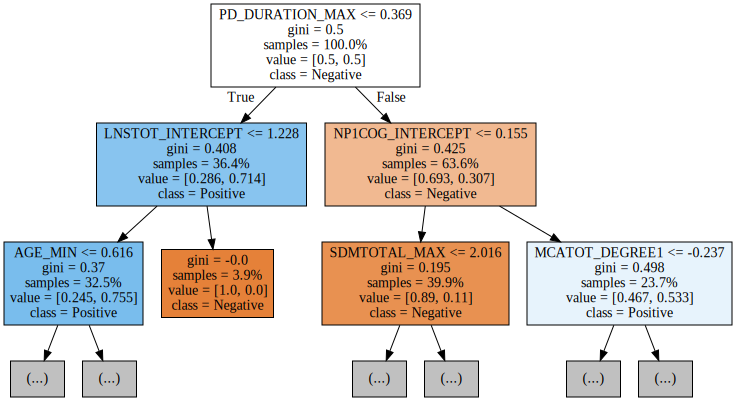

File already exists, are you sure you want to overwrite  DECISION_TREE_test.pdf  in the folder  C:/Users/Briggstone/Documents/Master 2020/Processed data/example ?


Y?: Y


In [94]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

if ENABLE_DECISION_TREE:
    
    if DECISION_TREE_TUNING_METHOD == 0:
        
        clf_DT = DecisionTreeClassifier(**DECISION_TREE_PARAMS)
        CV_report(clf_DT, train, train_Y, DECISION_TREE_K_FOLD, scoring, SAMPLING)
        
    if DECISION_TREE_TUNING_METHOD == 1:
        
        clf_DT = DecisionTreeClassifier(**DECISION_TREE_PARAMS)
        params = randomized_tuning(train,train_Y,clf_DT, DECISION_TREE_PARAMS_RANDOM_SEARCH, DECISION_TREE_K_FOLD, \
                                   DECISION_TREE_RANDOMSEARCH_N_ITER, scoring, refit, SAMPLING)
        
        clf_DT = DecisionTreeClassifier(**DECISION_TREE_PARAMS, **params)
        CV_report(clf_DT, train, train_Y, DECISION_TREE_K_FOLD, scoring, SAMPLING)
        
        
    if DECISION_TREE_TUNING_METHOD == 2:
        
        clf_DT = DecisionTreeClassifier(**DECISION_TREE_PARAMS)
        params = grid_tuning(train,train_Y,clf_DT, DECISION_TREE_PARAMS_GRID_SEARCH, DECISION_TREE_K_FOLD, scoring, refit, SAMPLING)
        
        clf_DT = DecisionTreeClassifier(**DECISION_TREE_PARAMS, **params)
        CV_report(clf_DT, train, train_Y, DECISION_TREE_K_FOLD, scoring, SAMPLING)

    if DECISION_TREE_SAVE_PARAMS_TO_DISK:
        params = clf_DT.get_params()
        save_string = output_filepath + '/' + FOLDER_NAME + '/DECISION_TREE_' + DECISION_TREE_FILE_NAME + '.txt'
        overwrite_protection(save_string)
        print("\nSaving hyperparameters to disk")
        with open(save_string, 'w') as f:
            json.dump(params, f) 
        
    if DECISION_TREE_PLOT_TREE:
        from IPython.display import SVG
        from graphviz import Source
        from IPython.display import display
        
        labels = train.columns
        
        fit = clf_DT.fit(train,train_Y)
        
        graph = tree.export_graphviz(fit, out_file=None, feature_names=labels, class_names=['Negative', 'Positive'],filled = True, \
                        max_depth = DECISION_TREE_MAX_DEPTH_TO_DISPLAY, proportion = True)
        graph_source = Source(graph)
        display(SVG(graph_source.pipe(format='svg')))
        
        if DECISION_TREE_SAVE_VISUALIZATION:
            save_string = output_filepath + '/' + FOLDER_NAME + '/DECISION_TREE_' + DECISION_TREE_IMAGE_NAME + '.pdf'
            overwrite_protection(save_string)
            save_string = save_string[0:-4]
            graph_source.render(save_string) 
            os.remove(save_string)

#### In this cell we set all flags and parameters for Random Forest

In [95]:
'''
    Flags and Parameters for Random Forest
'''
# 0 = No, 1 = Yes
ENABLE_RANDOM_FOREST = 0

#Number of folds to use in CV
RANDOM_FOREST_K_FOLD = 10

if ENABLE_RANDOM_FOREST:
    
    #Use this for your best CV_results, the txt file can later be used as the parameters for the model used in the final results
    # 0 = No, 1 = Yes
    RANDOM_FOREST_SAVE_PARAMS_TO_DISK = 1

    if RANDOM_FOREST_SAVE_PARAMS_TO_DISK:
        #Will be used to create a txt file in the same folder as train and test data with the name;
        #RANDOM_FOREST_[FILE_NAME].txt
        RANDOM_FOREST_FILE_NAME = "bestparams"
    
    #Use this to show a plot of estimated feature importance found from the trees constructed
    # 0 = No, 1 = Yes
    RANDOM_FOREST_SHOW_FEATURE_IMPORTANCE = 1
    if RANDOM_FOREST_SHOW_FEATURE_IMPORTANCE:
        #As the plot quickly becomes impoosible to read if a lot of features are included in the model
        RANDOM_FOREST_MAX_NUMBER_OF_FEATURES_TO_SHOW = 15
    
    #  0 = Manual parameters, 1 = RandomSearch, 2 = Gridsearch
    RANDOM_FOREST_TUNING_METHOD = 1
    
    if RANDOM_FOREST_TUNING_METHOD == 0:     
        
        #The parameters that will be used for manual tuning
        RANDOM_FOREST_PARAMS = {
          'colsample_bynode': 0.8,
            'n_estimators' : 1,
          'learning_rate': 1,
          'max_depth': 5,
          'num_parallel_tree': 100,
          'objective': 'binary:logistic',
          'subsample': 0.8,
          'scale_pos_weight' : pos_weights_scale
        }
    
    
    elif RANDOM_FOREST_TUNING_METHOD != 0:
        #Use this for parameters that you want to set,but not search through
        RANDOM_FOREST_PARAMS = {
            'n_estimators' : 1,
            'learning_rate': 1,
            'objective': 'binary:logistic',
            'scale_pos_weight' : pos_weights_scale
        }
        
        if RANDOM_FOREST_TUNING_METHOD == 1:
            
            #Set the number of random searches performed using the distributions provided
            #More iterations, likely better results, but worse performance
            RANDOM_FOREST_RANDOMSEARCH_N_ITER = 2
            
            #Use this to define the distributions to search through in randomsearch
            RANDOM_FOREST_PARAMS_RANDOM_SEARCH = { 'colsample_bynode': stats.uniform(0.5, 0.45),
              'max_depth': stats.randint(3,9),
              'subsample': stats.uniform(0.3, 0.6),
              'num_parallel_tree': stats.randint(50,200), 
              'max_delta_step' : stats.uniform(0,15)
             }
            
            
        elif RANDOM_FOREST_TUNING_METHOD == 2:
            #Use this to define the grid searched through in gridsearch
            RANDOM_FOREST_PARAMS_GRID_SEARCH = { 'colsample_bynode': [0.5,0.75],
              'max_depth': [3, 7],             
              'subsample': [0.5,0.75],
              'num_parallel_tree': [2,5],
              'max_delta_step' : [0,5]
             }
'''
'''

#Just to stop \n being printed out due to the open strings
clear = 1

#### In this cell we do random forest from XGBOOST

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    1.9s finished



For hyperparameter colsample_bynode  possible interval was : [ 0.5 , 0.95 ]. The value chosen by RandomSearch is:  0.7394212120896099

For hyperparameter max_depth  possible interval was : [ 2.0 , 8.0 ]. The value chosen by RandomSearch is:  5

For hyperparameter subsample  possible interval was : [ 0.3 , 0.8999999999999999 ]. The value chosen by RandomSearch is:  0.872578096411045

For hyperparameter num_parallel_tree  possible interval was : [ 49.0 , 199.0 ]. The value chosen by RandomSearch is:  159

For hyperparameter max_delta_step  possible interval was : [ 0.0 , 15.0 ]. The value chosen by RandomSearch is:  1.2321384694226456
Optimized for  MCC


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.5s finished



CV Report:

         Metric  Train mean  Train SD  Test mean   Test SD
0     accuracy    0.792671  0.042576   0.603202  0.123865
1    precision    0.530677  0.052352   0.338175  0.081780
2  sensitivity    1.000000  0.000000   0.621429  0.124835
3  specificity    0.730830  0.055388   0.601948  0.174361
4           f1    0.691874  0.044329   0.425008  0.070669
5      roc_auc    0.865415  0.027694   0.611688  0.078664
6          MCC    0.622720  0.054220   0.196162  0.137424
File already exists, are you sure you want to overwrite  RANDOM_FOREST_bestparams.txt  in the folder  C:/Users/Briggstone/Documents/Master 2020/Processed data/example ?


Y?: Y



Saving hyperparameters to disk
Plot of feature importance:


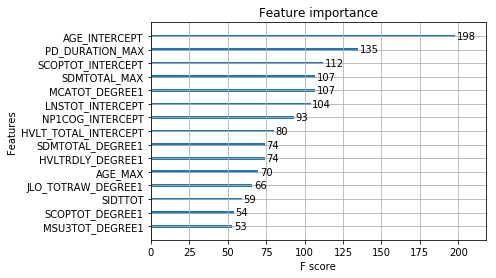

In [96]:
from xgboost.sklearn import XGBClassifier
import xgboost as xgb

if ENABLE_RANDOM_FOREST:
    
    if RANDOM_FOREST_TUNING_METHOD == 0:
        
        clf_RF = XGBClassifier(**RANDOM_FOREST_PARAMS)
        CV_report(clf_RF, train, train_Y, RANDOM_FOREST_K_FOLD, scoring, SAMPLING)
        
    if RANDOM_FOREST_TUNING_METHOD == 1:
        
        clf_RF = XGBClassifier(**RANDOM_FOREST_PARAMS)
        params = randomized_tuning(train,train_Y,clf_RF, RANDOM_FOREST_PARAMS_RANDOM_SEARCH, RANDOM_FOREST_K_FOLD, \
                                   RANDOM_FOREST_RANDOMSEARCH_N_ITER, scoring, refit, SAMPLING)
        
        clf_RF = XGBClassifier(**RANDOM_FOREST_PARAMS, **params)
        CV_report(clf_RF, train, train_Y, RANDOM_FOREST_K_FOLD, scoring, SAMPLING)
        
        
    if RANDOM_FOREST_TUNING_METHOD == 2:
        
        clf_RF = XGBClassifier(**RANDOM_FOREST_PARAMS)
        params = grid_tuning(train,train_Y,clf_RF, RANDOM_FOREST_PARAMS_GRID_SEARCH, RANDOM_FOREST_K_FOLD, scoring, refit, SAMPLING)
        
        clf_RF = XGBClassifier(**RANDOM_FOREST_PARAMS, **params)
        CV_report(clf_RF, train, train_Y, RANDOM_FOREST_K_FOLD, scoring, SAMPLING)

    if RANDOM_FOREST_SAVE_PARAMS_TO_DISK:
        params = clf_RF.get_params()
        save_string = output_filepath + '/' + FOLDER_NAME + '/RANDOM_FOREST_' + RANDOM_FOREST_FILE_NAME + '.txt'
        overwrite_protection(save_string)
        print("\nSaving hyperparameters to disk")
        with open(save_string, 'w') as f:
            json.dump(params, f)

    if RANDOM_FOREST_SHOW_FEATURE_IMPORTANCE:
        print("Plot of feature importance:")
        xgb.plot_importance(clf_RF.fit(train,train_Y), max_num_features = RANDOM_FOREST_MAX_NUMBER_OF_FEATURES_TO_SHOW)
        pyplot.show()  
        

#### In this cell we set all flags and parameters for boosted trees

In [97]:
'''
    Flags and Parameters for boosted trees
'''
# 0 = No, 1 = Yes
ENABLE_BOOSTED_TREES = 0

#Number of folds to use in CV
BOOSTED_TREES_K_FOLD = 10

if ENABLE_BOOSTED_TREES:
    
    #Use this for your best CV_results, the txt file can later be used as the parameters for the model used in the final results
    # 0 = No, 1 = Yes
    BOOSTED_TREES_SAVE_PARAMS_TO_DISK = 1

    if BOOSTED_TREES_SAVE_PARAMS_TO_DISK:
        #Will be used to create a txt file in the same folder as train and test data with the name;
        #BOOSTED_TREES_[FILE_NAME].txt
        BOOSTED_TREES_FILE_NAME = "bestparams"
    
     #Use this to show a plot of estimated feature importance found from the trees constructed
    # 0 = No, 1 = Yes
    BOOSTED_TREES_SHOW_FEATURE_IMPORTANCE = 1
    if BOOSTED_TREES_SHOW_FEATURE_IMPORTANCE:
        #As the plot quickly becomes impoosible to read if a lot of features are included in the model
        BOOSTED_TREES_MAX_NUMBER_OF_FEATURES_TO_SHOW = 15
    
    #  0 = Manual parameters, 1 = RandomSearch, 2 = Gridsearch
    BOOSTED_TREES_TUNING_METHOD = 1
    
    if BOOSTED_TREES_TUNING_METHOD == 0:     
        
        #The parameters that will be used for manual tuning
        BOOSTED_TREES_PARAMS = {
            'n_estimators' : 2,
            'learning_rate': 1,
            'max_depth': 2,
            'objective': 'binary:logistic',
            'scale_pos_weight':  pos_weights_scale
        }
    
    
    elif BOOSTED_TREES_TUNING_METHOD != 0:
        #Use this for parameters that you want to set,but not search through
        BOOSTED_TREES_PARAMS = {
            'objective': 'binary:logistic',
            'scale_pos_weight' : pos_weights_scale
        }
        
        if BOOSTED_TREES_TUNING_METHOD == 1:
            
            #Set the number of random searches performed using the distributions provided
            #More iterations, likely better results, but worse performance
            BOOSTED_TREES_RANDOMSEARCH_N_ITER = 20
            
            #Use this to define the distributions to search through in randomsearch
            BOOSTED_TREES_PARAMS_RANDOM_SEARCH = {'n_estimators': stats.randint(1, 100),
              'learning_rate': stats.uniform(0.01, 0.99),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': stats.randint(3,9),
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': stats.randint(1,3),
              'max_delta_step' : stats.uniform(0,15),
             }
            
            
        elif BOOSTED_TREES_TUNING_METHOD == 2:
            #Use this to define the grid searched through in gridsearch
            BOOSTED_TREES_PARAMS_GRID_SEARCH = {'n_estimators': [1,50],
              'learning_rate': [0.1,0.2],
              'subsample': [0.3,0.5],
              'max_depth': [3,5],
              'colsample_bytree': [0.5,0,7],
              'min_child_weight': [1,3],
              'max_delta_step' : [5,10],
             }
'''
'''

#Just to stop \n being printed out due to the open strings
clear = 1

#### In this cell we do boosted trees from XGBOOST

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   10.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.



For hyperparameter n_estimators  possible interval was : [ 0.0 , 99.0 ]. The value chosen by RandomSearch is:  60

For hyperparameter learning_rate  possible interval was : [ 0.01 , 1.0 ]. The value chosen by RandomSearch is:  0.17719820599214647

For hyperparameter subsample  possible interval was : [ 0.3 , 1.0 ]. The value chosen by RandomSearch is:  0.8731729108666793

For hyperparameter max_depth  possible interval was : [ 2.0 , 8.0 ]. The value chosen by RandomSearch is:  4

For hyperparameter colsample_bytree  possible interval was : [ 0.5 , 0.95 ]. The value chosen by RandomSearch is:  0.7062751130026329

For hyperparameter min_child_weight  possible interval was : [ 0.0 , 2.0 ]. The value chosen by RandomSearch is:  1

For hyperparameter max_delta_step  possible interval was : [ 0.0 , 15.0 ]. The value chosen by RandomSearch is:  14.862578070426062
Optimized for  MCC


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.7s finished



CV Report:

         Metric  Train mean  Train SD  Test mean   Test SD
0     accuracy    0.999608  0.001176   0.748645  0.067970
1    precision    0.998333  0.005000   0.485595  0.106091
2  sensitivity    1.000000  0.000000   0.523810  0.101575
3  specificity    0.999490  0.001531   0.816667  0.101395
4           f1    0.999160  0.002521   0.491026  0.074503
5      roc_auc    0.999745  0.000765   0.670238  0.048035
6          MCC    0.998910  0.003270   0.337778  0.099942
File already exists, are you sure you want to overwrite  BOOSTED_TREES_bestparams.txt  in the folder  C:/Users/Briggstone/Documents/Master 2020/Processed data/example ?


Y?: Y



Saving hyperparameters to disk
Plot of feature importance:


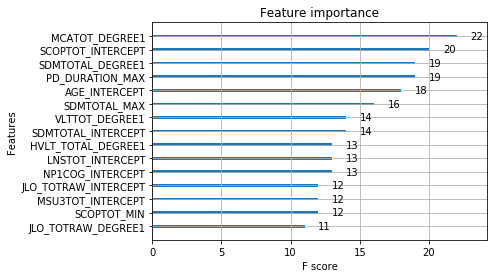

In [98]:
from xgboost.sklearn import XGBClassifier

if ENABLE_BOOSTED_TREES:
    
    if BOOSTED_TREES_TUNING_METHOD == 0:
        
        clf_BT = XGBClassifier(**BOOSTED_TREES_PARAMS)
        CV_report(clf_BT, train, train_Y, BOOSTED_TREES_K_FOLD, scoring, SAMPLING)
        
    if BOOSTED_TREES_TUNING_METHOD == 1:
        
        clf_BT = XGBClassifier(**BOOSTED_TREES_PARAMS)
        params = randomized_tuning(train,train_Y,clf_BT, BOOSTED_TREES_PARAMS_RANDOM_SEARCH, BOOSTED_TREES_K_FOLD, \
                                   BOOSTED_TREES_RANDOMSEARCH_N_ITER, scoring, refit, SAMPLING)
        
        clf_BT = XGBClassifier(**BOOSTED_TREES_PARAMS, **params)
        CV_report(clf_BT, train, train_Y, BOOSTED_TREES_K_FOLD, scoring, SAMPLING)
        
        
    if BOOSTED_TREES_TUNING_METHOD == 2:
        
        clf_BT = XGBClassifier(**BOOSTED_TREES_PARAMS)
        params = grid_tuning(train,train_Y,clf_BT, BOOSTED_TREES_PARAMS_GRID_SEARCH, BOOSTED_TREES_K_FOLD, scoring, refit, SAMPLING)
        
        clf_BT = XGBClassifier(**BOOSTED_TREES_PARAMS, **params)
        CV_report(clf_BT, train, train_Y, BOOSTED_TREES_K_FOLD, scoring, SAMPLING)

    if BOOSTED_TREES_SAVE_PARAMS_TO_DISK:
        params = clf_BT.get_params()
        save_string = output_filepath + '/' + FOLDER_NAME + '/BOOSTED_TREES_' + BOOSTED_TREES_FILE_NAME + '.txt'
        overwrite_protection(save_string)
        print("\nSaving hyperparameters to disk")
        with open(save_string, 'w') as f:
            json.dump(params, f)

    if BOOSTED_TREES_SHOW_FEATURE_IMPORTANCE:
        print("Plot of feature importance:")
        xgb.plot_importance(clf_BT.fit(train,train_Y), max_num_features = BOOSTED_TREES_MAX_NUMBER_OF_FEATURES_TO_SHOW)
        pyplot.show()  
        
        

#### In this cell we define flags and options for getting the final results from tuned models

In [99]:
'''
    Flags and Parameters for final results
'''
# 0 = No, 1 = Yes
ENABLE_FINAL_RESULTS = 0

if ENABLE_FINAL_RESULTS:
    
    #Number of folds used for CV results
    FINAL_RESULTS_K_FOLDS = 10
    
    
    #The metrics that will be reported on
    #These are the metrics we have used before, additional metrics are easily implemented if sklearn has it implemented
    '''
    'accuracy': met.make_scorer(met.accuracy_score),
    'precision': met.make_scorer(met.precision_score),
    'sensitivity': met.make_scorer(met.recall_score),
    'specificity': met.make_scorer(met.recall_score,pos_label = 0),
    'f1': met.make_scorer(met.f1_score),
    'roc_auc': met.make_scorer(met.roc_auc_score),
    "MCC" : met.make_scorer(met.matthews_corrcoef)
    '''
    
    FINAL_RESULTS_METRICS = {
        'accuracy': met.make_scorer(met.accuracy_score),
        'precision': met.make_scorer(met.precision_score),
        'sensitivity': met.make_scorer(met.recall_score),
        'specificity': met.make_scorer(met.recall_score,pos_label = 0),
        'f1': met.make_scorer(met.f1_score),
        'roc_auc': met.make_scorer(met.roc_auc_score),
        "MCC" : met.make_scorer(met.matthews_corrcoef)
    }
                            
    
    # 0 = No, 1 = Yes
    REPORT_CV_TRAIN_MEAN = 1
    REPORT_CV_TRAIN_STD = 1

    # 0 = No, 1 = Yes
    REPORT_CV_TEST_MEAN = 1
    REPORT_CV_TEST_STD = 1

    # For actual train and test data, not CV
    # 0 = No, 1 = Yes
    REPORT_TRAIN = 1
    REPORT_TEST = 1

    
    
    # 0 = No, 1 = Yes
    FINAL_RESULTS_LOGISTIC_REGRESSION = 1
    if FINAL_RESULTS_LOGISTIC_REGRESSION:
        #text file with the params you want to use in the final results
        LOGISTIC_REGRESSION_PARAMS = "bestparams.txt" 
       
    # 0 = No, 1 = Yes
    FINAL_RESULTS_SVM = 1
    if FINAL_RESULTS_SVM:
        #text file with the params you want to use in the final results
        SVM_PARAMS = "bestparams.txt"
        
    # 0 = No, 1 = Yes
    FINAL_RESULTS_DECISION_TREE = 1
    if FINAL_RESULTS_DECISION_TREE:
        #text file with the params you want to use in the final results
        DECISION_TREE_PARAMS = "bestparams.txt"
           
    # 0 = No, 1 = Yes
    FINAL_RESULTS_RANDOM_FOREST = 1
    if FINAL_RESULTS_RANDOM_FOREST:
        #text file with the params you want to use in the final results
        RANDOM_FOREST_PARAMS = "bestparams.txt"
        
    # 0 = No, 1 = Yes
    FINAL_RESULTS_BOOSTED_TREES = 1
    if FINAL_RESULTS_BOOSTED_TREES:
        #text file with the params you want to use in the final results
        DECISION_TREE_PARAMS = "bestparams.txt"
     
    # 0 = No, 1 = Yes
    #Will be saved as a csv file with the name specified in the currently used folder 
    SAVE_FINAL_RESULTS = 1
        
    if SAVE_FINAL_RESULTS:
        
        FINAL_RESULTS_FILE_NAME = "final_results"
        
        
    

In [100]:
def cv_report_helper_function (rows_list, model_string, cv_report):

    if REPORT_CV_TRAIN_MEAN:
        results = { "Result_Type" : model_string + "CV_TRAIN_MEAN"}
        for k,_ in FINAL_RESULTS_METRICS.items():
            results[k] = cv_report.loc[cv_report["Metric"] == k, "Train mean"].values[0]
            
        rows_list.append(results)
        
    if REPORT_CV_TRAIN_STD:
        results = { "Result_Type" : model_string + "CV_TRAIN_STD"}
        for k,_ in FINAL_RESULTS_METRICS.items():
            results[k] = cv_report.loc[cv_report["Metric"] == k, "Train SD"].values[0]

        rows_list.append(results)
        
        
    if REPORT_CV_TEST_MEAN:
        results = { "Result_Type" : model_string + "CV_TEST_MEAN"}
        for k,_ in FINAL_RESULTS_METRICS.items():
            results[k] = cv_report.loc[cv_report["Metric"] == k, "Test mean"].values[0]

        rows_list.append(results)
        
    if REPORT_CV_TEST_STD:
        results = { "Result_Type" : model_string + "CV_TEST_STD"}
        for k,_ in FINAL_RESULTS_METRICS.items():
            results[k] = cv_report.loc[cv_report["Metric"] == k, "Test SD"].values[0]

        rows_list.append(results)
        
        
def scorer_helper_function(y_true,y_pred,scorer_string):
    
    if scorer_string == "accuracy":
        return met.accuracy_score(y_true, y_pred)
    elif scorer_string == "precision":
        return met.precision_score(y_true,y_pred)
    elif scorer_string == "sensitivity":
        return met.recall_score(y_true,y_pred)
    elif scorer_string == "specificity":
        return met.recall_score(y_true,y_pred, pos_label = 0)
    elif scorer_string == "f1":
        return met.f1_score(y_true,y_pred)
    elif scorer_string == "roc_auc":
        return met.roc_auc_score(y_true,y_pred)
    elif scorer_string == "MCC":
        return met.matthews_corrcoef(y_true,y_pred)
        
        
def results_helper_function(rows_list, model_string, model):
    
    if SAMPLING != "NONE":
        if SAMPLING == "SMOTE":
            model = over_sampling(model,train)
     
    fit = model.fit(train,train_Y)
    if REPORT_TRAIN:
        results_train = fit.predict(train)
        
        results = { "Result_Type" : model_string + "TRAIN"}
        
        for k,_ in FINAL_RESULTS_METRICS.items():
            results[k] = scorer_helper_function(train_Y,results_train,k)
            
        rows_list.append(results)
        
    if REPORT_TEST:
        results_test = fit.predict(test)
               
        results = { "Result_Type" : model_string + "TEST"}
        
        for k,_ in FINAL_RESULTS_METRICS.items():
            results[k] = scorer_helper_function(test_Y, results_test, k)
            
        rows_list.append(results)
        
    

if ENABLE_FINAL_RESULTS:
    
    columns = ["Result_Type"]
    for k,_ in FINAL_RESULTS_METRICS.items():
        columns.append(k)
    
    
    df = pd.DataFrame(columns = columns)
    rows_list = []
    
    if FINAL_RESULTS_LOGISTIC_REGRESSION:
        filepath = output_filepath + '/' + FOLDER_NAME + '/LOGISTIC_REGRESSION_' + LOGISTIC_REGRESSION_PARAMS
        with open(filepath,'r') as f:
            params = json.load(f)
        
        clf_log = LogisticRegression(**params)
        
        if REPORT_CV_TRAIN_MEAN or REPORT_CV_TRAIN_STD or REPORT_CV_TEST_MEAN or REPORT_CV_TEST_STD:
            
            results = CV_report(clf_log, train, train_Y, FINAL_RESULTS_K_FOLDS, FINAL_RESULTS_METRICS, SAMPLING, return_results = True)
            cv_report_helper_function(rows_list, "LOGISTIC_REGRESSION_", results)
            results_helper_function(rows_list, "LOGISTIC_REGRESSION_", clf_log)
        
    if FINAL_RESULTS_SVM:
        filepath = output_filepath + '/' + FOLDER_NAME + '/SVM_' + SVM_PARAMS
        with open(filepath,'r') as f:
            params = json.load(f)
        
        clf_svm = svm.SVC(**params)
        
        if REPORT_CV_TRAIN_MEAN or REPORT_CV_TRAIN_STD or REPORT_CV_TEST_MEAN or REPORT_CV_TEST_STD:
            
            results = CV_report(clf_svm, train, train_Y, FINAL_RESULTS_K_FOLDS, FINAL_RESULTS_METRICS, SAMPLING, return_results = True)
            cv_report_helper_function(rows_list, "SVM_", results)
            results_helper_function(rows_list, "SVM_", clf_log)   
            
     
    if FINAL_RESULTS_DECISION_TREE:
        filepath = output_filepath + '/' + FOLDER_NAME + '/DECISION_TREE_' + DECISION_TREE_PARAMS
        with open(filepath,'r') as f:
            params = json.load(f)

        clf_DT = DecisionTreeClassifier(**params)

        if REPORT_CV_TRAIN_MEAN or REPORT_CV_TRAIN_STD or REPORT_CV_TEST_MEAN or REPORT_CV_TEST_STD:

            results = CV_report(clf_DT, train, train_Y, FINAL_RESULTS_K_FOLDS, FINAL_RESULTS_METRICS, SAMPLING, return_results = True)
            cv_report_helper_function(rows_list, "DECISION_TREE_", results)
            results_helper_function(rows_list, "DECISION_TREE_", clf_log)   


    if FINAL_RESULTS_RANDOM_FOREST:
        filepath = output_filepath + '/' + FOLDER_NAME + '/RANDOM_FOREST_' + DECISION_TREE_PARAMS
        with open(filepath,'r') as f:
            params = json.load(f)

        clf_RF = XGBClassifier(**params)

        if REPORT_CV_TRAIN_MEAN or REPORT_CV_TRAIN_STD or REPORT_CV_TEST_MEAN or REPORT_CV_TEST_STD:

            results = CV_report(clf_RF, train, train_Y, FINAL_RESULTS_K_FOLDS, FINAL_RESULTS_METRICS, SAMPLING, return_results = True)
            cv_report_helper_function(rows_list, "RANDOM_FOREST_", results)
            results_helper_function(rows_list, "RANDOM_FOREST_", clf_log)   
    
    
    if FINAL_RESULTS_BOOSTED_TREES:
        filepath = output_filepath + '/' + FOLDER_NAME + '/BOOSTED_TREES_' + DECISION_TREE_PARAMS
        with open(filepath,'r') as f:
            params = json.load(f)

        clf_BT = XGBClassifier(**params)

        if REPORT_CV_TRAIN_MEAN or REPORT_CV_TRAIN_STD or REPORT_CV_TEST_MEAN or REPORT_CV_TEST_STD:

            results = CV_report(clf_BT, train, train_Y, FINAL_RESULTS_K_FOLDS, FINAL_RESULTS_METRICS, SAMPLING, return_results = True)
            cv_report_helper_function(rows_list, "BOOSTED_TREES_", results)
            results_helper_function(rows_list, "BOOSTED_TREES_", clf_log)      
    
    
   
    results = df.append(pd.DataFrame(rows_list), sort = False)
                
    display(results)        
            
       
    if SAVE_FINAL_RESULTS:
        save_string = output_filepath + '/' + FOLDER_NAME + '/' + FINAL_RESULTS_FILE_NAME + '.csv'
        overwrite_protection(save_string)
        print("\nSaving results to disk")
        results.to_csv(save_string, index = False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.7s finished


,Result_Type,accuracy,precision,sensitivity,specificity,f1,roc_auc,MCC
0,LOGISTIC_REGRESSION_CV_TRAIN_MEAN,0.888510,0.749039,0.779544,0.920986,0.763315,0.850265,0.691258
1,LOGISTIC_REGRESSION_CV_TRAIN_STD,0.015320,0.044059,0.017056,0.018606,0.025479,0.013045,0.035425
2,LOGISTIC_REGRESSION_CV_TEST_MEAN,0.696798,0.336071,0.366667,0.799134,0.335133,0.582900,0.153865
3,LOGISTIC_REGRESSION_CV_TEST_STD,0.063965,0.147586,0.205149,0.075645,0.161147,0.096789,0.187253
4,LOGISTIC_REGRESSION_TRAIN,0.865724,0.684932,0.769231,0.894495,0.724638,0.831863,0.638121
5,LOGISTIC_REGRESSION_TEST,0.726027,0.454545,0.555556,0.781818,0.500000,0.668687,0.316907
6,SVM_CV_TRAIN_MEAN,0.950920,0.862461,0.938515,0.954633,0.898100,0.946574,0.867923
7,SVM_CV_TRAIN_STD,0.010005,0.035630,0.024346,0.015225,0.018090,0.010435,0.022793
8,SVM_CV_TEST_MEAN,0.741872,0.485335,0.464286,0.825758,0.453521,0.645022,0.302374
9,SVM_CV_TEST_STD,0.067998,0.213612,0.132673,0.090331,0.121603,0.066707,0.171552


File already exists, are you sure you want to overwrite  final_results.csv  in the folder  C:/Users/Briggstone/Documents/Master 2020/Processed data/example ?


Y?: Y



Saving results to disk
